In [2]:
from src.simulation.simulation import *
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

from src.utils.dataset_utils import *
from src.utils.plot_builder.plot_builder import *
from src.utils.plot_builder.plot_types import *

In [3]:
number_of_frames    = 250
discretization_size = 290
d                   = (0.1, 0.3, 0.3)
N                   = (number_of_frames, discretization_size, discretization_size)
myu_size            = (50, 10, 10)
myu_mstd            = (5.4, 0.6)

sim = Simulation(
    d=d,
    N=N,
    myu_size=myu_size,
    myu_mstd=myu_mstd
)

state, myu = sim.compute()

Computing States: 100%|██████████| 249/249 [00:03<00:00, 70.90it/s]


In [4]:
myu.shape

(250, 290, 290)

In [5]:
myu[100]

array([[6.1875571 , 6.1875571 , 6.1875571 , ..., 4.74606266, 4.74606266,
        4.74606266],
       [6.1875571 , 6.1875571 , 6.1875571 , ..., 4.74606266, 4.74606266,
        4.74606266],
       [6.1875571 , 6.1875571 , 6.1875571 , ..., 4.74606266, 4.74606266,
        4.74606266],
       ...,
       [5.01658399, 5.01658399, 5.01658399, ..., 4.46490425, 4.46490425,
        4.46490425],
       [5.01658399, 5.01658399, 5.01658399, ..., 4.46490425, 4.46490425,
        4.46490425],
       [5.01658399, 5.01658399, 5.01658399, ..., 4.46490425, 4.46490425,
        4.46490425]])

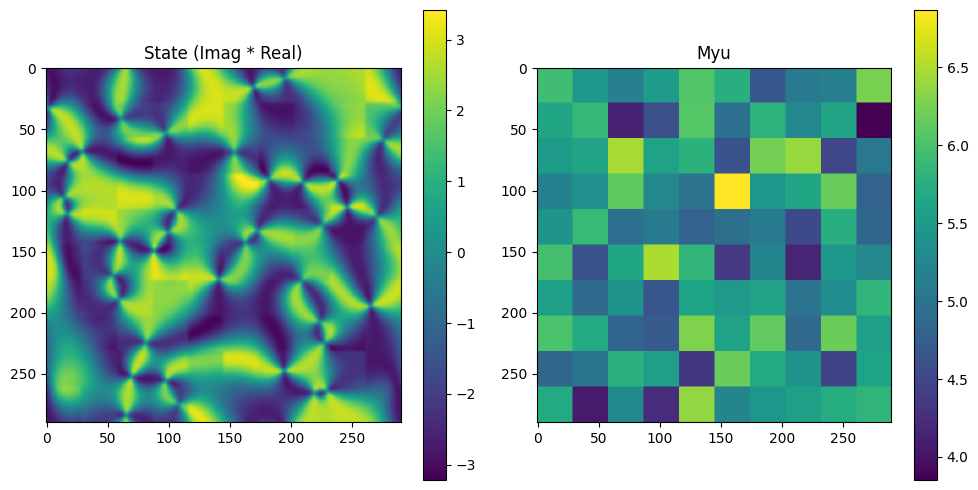

((250, 290, 290), (250, 290, 290))

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img1 = ax[0].imshow(state[249].imag * state[249].real)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title("State (Imag * Real)")

img2 = ax[1].imshow(myu[249])
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Myu")

plt.tight_layout()
plt.show()

state.shape, myu.shape

In [4]:
pb = PlotBuilder()

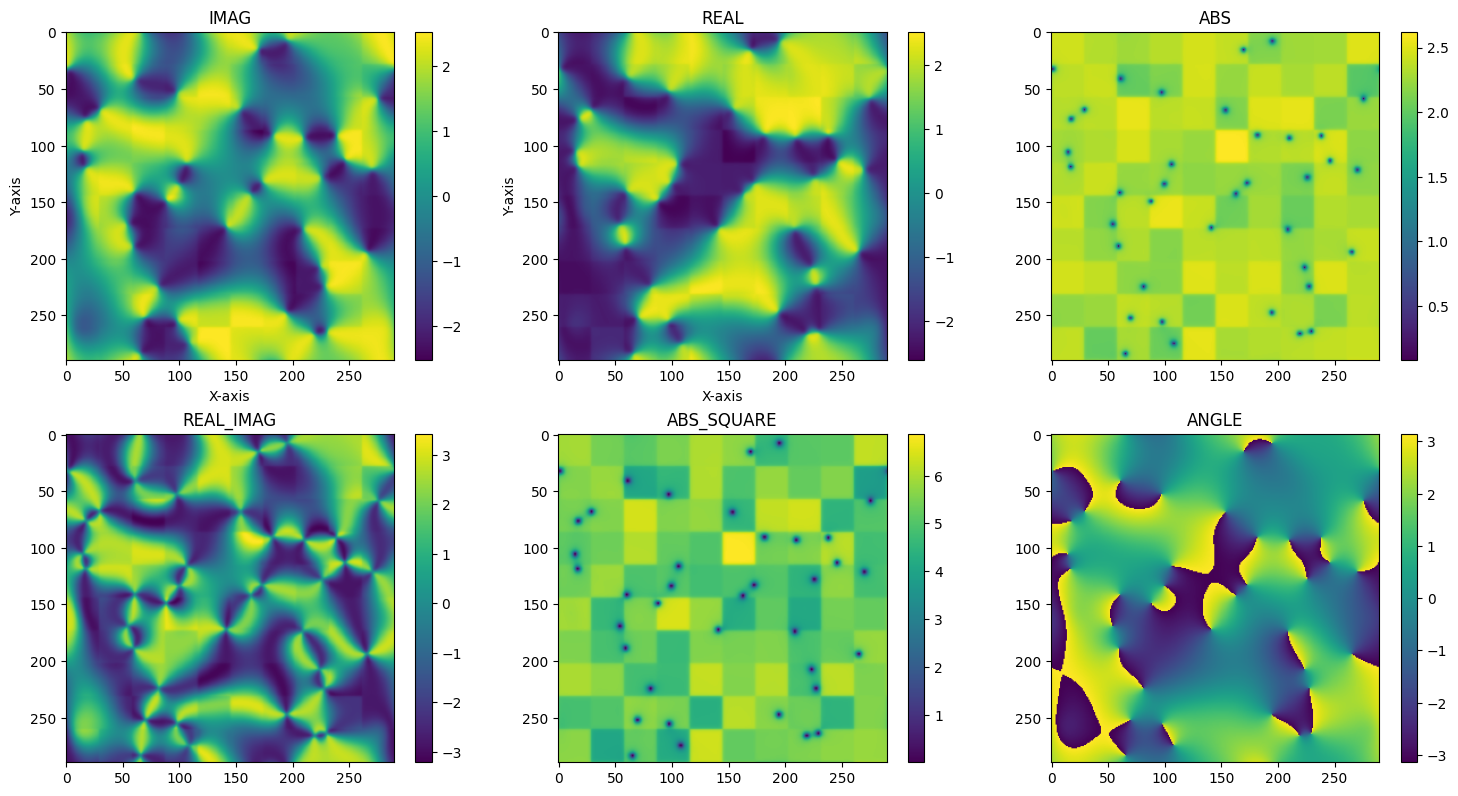

In [5]:
(fig, axes) = (
    pb
    .set_grid(2, 3)
    .add_plot(0, state[state.shape[0]-1], plot_type=PlotType.IMAG, title="IMAG", xlabel="X-axis", ylabel="Y-axis", colorbar=True)
    .add_plot(1, state[state.shape[0]-1], plot_type=PlotType.REAL, title="REAL", xlabel="X-axis", ylabel="Y-axis", colorbar=True)
    .add_plot(2, state[state.shape[0]-1], plot_type=PlotType.ABS, title="ABS", colorbar=True)
    .add_plot(3, state[state.shape[0]-1], plot_type=PlotType.REAL_IMAG, title="REAL_IMAG", colorbar=True)
    .add_plot(4, state[state.shape[0]-1], plot_type=PlotType.ABS_SQUARE, title="ABS_SQUARE", colorbar=True)
    .add_plot(5, state[state.shape[0]-1], plot_type=PlotType.ANGLE, title="ANGLE", colorbar=True)
    .build()
)
plt.show()

In [6]:
dataset = GLDataset(state=state, myu=myu)

In [7]:
dataloader = GLDataLoader(dataset=dataset)

In [8]:
from src.models.simple_dnn import SimpleDNN

dataset = StateDataset(state, myu)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=torch.cuda.is_available(), num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleDNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [9]:
scaler = GradScaler(enabled=torch.cuda.is_available())

C:\Users\meloy\AppData\Local\Temp\ipykernel_11720\3821872068.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [10]:
epochs = 1
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

    for inputs, targets in progress_bar:
        # Move data to GPU if available
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed Precision Training
        with autocast(enabled=torch.cuda.is_available()):
            predictions = model(inputs)
            loss = criterion(predictions, targets)

        # Backpropagation with Mixed Precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Average Loss: {epoch_loss / len(dataloader):.6f}")

Epoch 1/1:   0%|          | 0/82129 [00:00<?, ?it/s]C:\Users\meloy\AppData\Local\Temp\ipykernel_14792\1780221075.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Epoch 1/1: 100%|██████████| 82129/82129 [05:06<00:00, 267.59it/s, loss=0.0876]

Epoch 1, Average Loss: 0.191218


In [21]:
torch.save(model.state_dict(), "../src/models/state_predictor.pth")
print("Training complete.")
print("Model saved to 'state_predictor.pth'")

Training complete.
Model saved to 'state_predictor.pth'


In [10]:
model.load_state_dict(torch.load("../src/models/state_predictor.pth"))
model.eval().to(device)

C:\Users\meloy\AppData\Local\Temp\ipykernel_11720\3568433873.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../src/models/state_predic

SimpleDNN(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [13]:
def predict_linespace(t_values, x_values, y_values, model, device):
    grid = torch.tensor([
        [t, x, y] for t in t_values for x in x_values for y in y_values
    ], dtype=torch.float32, device=device)  # Move grid directly to the correct device

    with torch.no_grad():
        predictions = model(grid)  # Model and grid are on the same device

    real_parts = predictions[:, 0].reshape(len(t_values), len(x_values), len(y_values))
    imag_parts = predictions[:, 1].reshape(len(t_values), len(x_values), len(y_values))

    return real_parts, imag_parts

In [12]:
torch.linspace(start=0, end=250, steps=2)

tensor([  0., 250.])

In [14]:
# Generate grid values
t_values = torch.linspace(0, 1, 200, device=device)
x_values = torch.linspace(0, 1, 200, device=device)
y_values = torch.linspace(0, 1, 200, device=device)

real_parts, imag_parts = predict_linespace(t_values, x_values, y_values, model, device)

print("Real parts shape:", real_parts.shape)
print("Imaginary parts shape:", imag_parts.shape)

Real parts shape: torch.Size([200, 200, 200])
Imaginary parts shape: torch.Size([200, 200, 200])


In [17]:
u_pred = real_parts + 1j * imag_parts

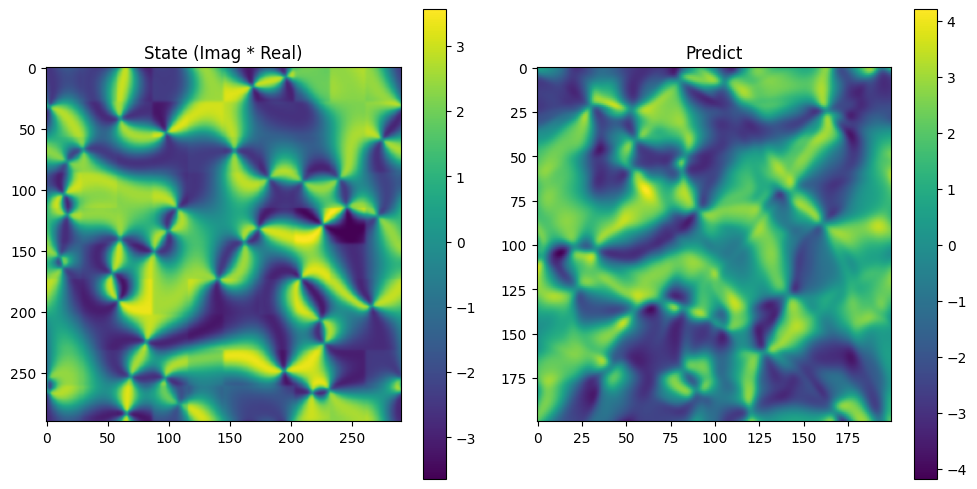

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img1 = ax[0].imshow(state[199].imag * state[199].real)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title("State (Imag * Real)")

img2 = ax[1].imshow(u_pred[199].detach().cpu().imag * u_pred[199].detach().cpu().real)
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Predict")

plt.tight_layout()
plt.show()

In [1]:
import torch

print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Available GPUs:
GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
import torch

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Check the current device being used
print(f"Current device index: {torch.cuda.current_device()}")

# Print the name of the current GPU
print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA available: True
Current device index: 0
Device name: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class NOPINN(nn.Module):
    def __init__(
        self,
        layers,  # [3, 64, 64, 2]
        Nt, Nx_down, Ny_down,
        dt, dx, dy,
        degrade_x, degrade_y,
        delta=1.0,
        myu_init=None,  # shape: (Nt, Nx_down, Ny_down)
        weight_pde=1.0,
        dropout_rate=0.1,
        device='cuda:0'
    ):
        super(NOPINN, self).__init__()
        self.device = device
        self.delta = delta
        self.weight_pde = weight_pde

        self.dnn = self._build_network(layers, dropout_rate).to(device)
        self.Nt, self.Nx_down, self.Ny_down = Nt, Nx_down, Ny_down
        self.dt, self.dx, self.dy = dt, dx, dy
        self.degrade_x, self.degrade_y = degrade_x, degrade_y

        if myu_init is None:
            init = torch.zeros(Nt, Nx_down, Ny_down)
        else:
            init = torch.tensor(myu_init, dtype=torch.float32)
        self.mu_small = nn.Parameter(init.to(device))

    def _build_network(self, layers, dropout_rate):
        net = []
        for i in range(len(layers) - 1):
            net.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                net.append(nn.SiLU())  # Swish activation
                net.append(nn.Dropout(dropout_rate))  # Dropout
        return nn.Sequential(*net)

    def net_A(self, x, y, t):
        inp = torch.cat([x, y, t], dim=1)
        out = self.dnn(inp)
        return out[:, 0:1], out[:, 1:2]

    def get_mu(self, x, y, t):
        i = (t[:, 0] / self.dt).round().long().clamp(0, self.Nt - 1)
        j = (x[:, 0] / (self.dx * self.degrade_x)).floor().long().clamp(0, self.Nx_down - 1)
        k = (y[:, 0] / (self.dy * self.degrade_y)).floor().long().clamp(0, self.Ny_down - 1)
        return self.mu_small[i, j, k].view(-1, 1)

    def pde_residual(self, x, y, t):
        A_r, A_i = self.net_A(x, y, t)
        mu_vals = self.get_mu(x, y, t)

        A_r_t = torch.autograd.grad(A_r, t, torch.ones_like(A_r), create_graph=True, retain_graph=True)[0]
        A_i_t = torch.autograd.grad(A_i, t, torch.ones_like(A_i), create_graph=True, retain_graph=True)[0]

        A_r_x = torch.autograd.grad(A_r, x, torch.ones_like(A_r), create_graph=True, retain_graph=True)[0]
        A_i_x = torch.autograd.grad(A_i, x, torch.ones_like(A_i), create_graph=True, retain_graph=True)[0]

        A_r_y = torch.autograd.grad(A_r, y, torch.ones_like(A_r), create_graph=True, retain_graph=True)[0]
        A_i_y = torch.autograd.grad(A_i, y, torch.ones_like(A_i), create_graph=True, retain_graph=True)[0]

        A_r_xx = torch.autograd.grad(A_r_x, x, torch.ones_like(A_r_x), create_graph=True, retain_graph=True)[0]
        A_r_yy = torch.autograd.grad(A_r_y, y, torch.ones_like(A_r_y), create_graph=True, retain_graph=True)[0]

        A_i_xx = torch.autograd.grad(A_i_x, x, torch.ones_like(A_i_x), create_graph=True, retain_graph=True)[0]
        A_i_yy = torch.autograd.grad(A_i_y, y, torch.ones_like(A_i_y), create_graph=True, retain_graph=True)[0]

        lapA_r = A_r_xx + A_r_yy
        lapA_i = A_i_xx + A_i_yy

        A_abs2 = A_r**2 + A_i**2
        f_r = A_r_t - mu_vals * A_r - self.delta * lapA_r + A_abs2 * A_r
        f_i = A_i_t - mu_vals * A_i - self.delta * lapA_i + A_abs2 * A_i

        return f_r, f_i

    def loss_pde(self, x_eqs, y_eqs, t_eqs):
        f_r, f_i = self.pde_residual(x_eqs, y_eqs, t_eqs)
        return torch.mean(f_r**2 + f_i**2)

    def loss_data(self, x_data, y_data, t_data, A_r_data, A_i_data):
        A_r_pred, A_i_pred = self.net_A(x_data, y_data, t_data)
        return torch.mean((A_r_pred - A_r_data)**2 + (A_i_pred - A_i_data)**2)

    def train_model(self,
                    x_data, y_data, t_data, A_r_data, A_i_data,
                    x_eqs, y_eqs, t_eqs,
                    n_epochs=3000, lr=1e-3, weight_decay=1e-4, clip_value=1.0):
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=200, min_lr=1e-6)
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            l_pde = self.loss_pde(x_eqs, y_eqs, t_eqs)
            l_data = self.loss_data(x_data, y_data, t_data, A_r_data, A_i_data)
            loss = l_data + self.weight_pde * l_pde
            loss.backward()
            nn.utils.clip_grad_norm_(self.parameters(), clip_value)
            optimizer.step()

            scheduler.step(loss)

            if epoch % 500 == 0:
                print(f"Epoch {epoch}: total={loss.item():.4e}, data={l_data.item():.4e}, pde={l_pde.item():.4e}")

    def predict(self, x_star, y_star, t_star):
        self.eval()
        with torch.no_grad():
            A_r, A_i = self.net_A(x_star, y_star, t_star)
        return A_r.cpu().numpy(), A_i.cpu().numpy()

    def predict_myu_small(self):
        return self.mu_small.detach().cpu().numpy()